# 08 Gradient Descent

## The Idea Behind Gradient Descent

Suppose we have some function `f` that takes as input a vector of real numbers and outputs a single real number. One simple such function is:

In [1]:
from scratchlib.linalg import Vector
from scratchlib.linalg import dot

In [2]:
def sum_of_squares(v:Vector) -> float:
    """Computes the sum of squared elements in v"""
    return dot(v, v)

We’ll frequently need to maximize or minimize such functions. That is, we need to find the input `v` that produces the largest (or smallest) possible value.


For functions like ours, the gradient (if you remember your calculus, this is the vector of partial derivatives) gives the input direction in which the function most quickly increases. (If you don’t remember your calculus, take my word for it or look it up on the internet.)


Accordingly, one approach to maximizing a function is to pick a random starting point, compute the gradient, take a small step in the direction of the gradient (i.e., the direction that causes the function to increase the most), and repeat with the new starting point. Similarly, you can try to minimize a function by taking small steps in the opposite direction.

NOTE:

If a function has a unique global minimum, this procedure is likely to find it. If a function has multiple (local) minima, this procedure might “find” the wrong one of them, in which case you might rerun the procedure from different starting points. If a function has no minimum, then it’s possible the procedure might go on forever.

## Estimating the Gradient

If `f` is a function of one vriable, its derivative at a point `x` measures how `f(x)` changes when we make a very small change to `x`. The derivative is defined as the limit of the difference quotients:

In [3]:
from typing import Callable

def difference_quotient(f:Callable[[float], float],
                        x:float,
                        h:float) -> float:
    return (f(x + h) - f(x)) / h

as `h` approaches zero.

The derivative is the slope of the tangent line at $(x, f(x))$ , while the difference quotient is the slope of the not-quite-tangent line that runs through $(x + h, f(x + h)$. As h gets smaller and smaller, the not-quite- tangent line gets closer and closer to the tangent line

For many functions it’s easy to exactly calculate derivatives. For example, the function:

In [4]:
def square(x:float) -> float:
    return x * x

has the derivative:

In [5]:
def square_derivative(x:float) -> float:
    return 2 * x

which is easy for us to check by explicitly computing the difference quotient and taking the limit. (Doing so requires nothing more than high school algebra.)
What if you couldn’t (or didn’t want to) find the gradient? Although we can’t take limits in Python, we can estimate derivatives by evaluating the difference quotient for a very small `e`.

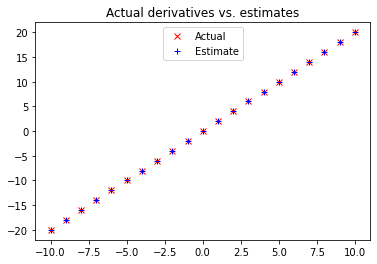

In [6]:
xs = range(-10, 11)
actuals = [square_derivative(x) for x in xs]
estimates = [difference_quotient(square, x, h=0.001) for x in xs]

# plot to show they're basically the same
import matplotlib.pyplot as plt
plt.title('Actual derivatives vs. estimates')
plt.plot(xs, actuals, 'rx', label='Actual')
plt.plot(xs, estimates, 'b+', label='Estimate')
plt.legend(loc=9)
plt.show()

When `f` is a function of many variables, it has multiple partial derivatives, each indicating how changes when we make small changes in just one of the input variables.
We calculate its ith partial derivative by treating it as a function of just its
ith variable, holding the other variables fixed:

In [7]:
def partial_difference_quotient(f:Callable[[Vector], float],
                                v:Vector,
                                i:int,
                                h:float) -> float:
    """Returns the i-th partial difference quotient of `f` at `v`"""
    w = [v_j + (h if j == i else 0)
             for j, v_j in enumerate(v)]
    return (f(w) - f(v)) / h

after which we can estimate the gradient the same way:

In [8]:
def estimate_gradient(f:Callable[[Vector], float],
                      v:Vector,
                      h:float=0.0001) -> Vector:
    return [partial_difference_quotient(f, v, i, h)
                for i in range(0, len(v))]

## Using the Gradient

It’s easy to see that `sum_of_squares` the function is smallest when its input `v` is a vector of zeros. But imagine we didn’t know that. Let’s use gradients
to find the minimum among all three-dimensional vectors. We’ll just pick a random starting point and then take tiny steps in the opposite direction of the gradient until we reach a point where the gradient is very small:

In [9]:
import random
from scratchlib.linalg import distance
from scratchlib.linalg import add
from scratchlib.linalg import scalar_multiply

def gradient_step(v:Vector, gradient:Vector, step_size:float) -> Vector:
    """Moves `step_size` in the `gradient` direction from `v`"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

def sum_of_squares_gradient(v:Vector) -> Vector:
    return [2 * v_i for v_i in v]

# pick a random starting point
v = [random.uniform(-10, 10) for i in range(0, 3)]

for epoch in range(0, 1001):
    grad = sum_of_squares_gradient(v)
    v = gradient_step(v, grad, -0.01)
    if epoch % 100 == 0:
        print(epoch, v)

assert distance(v, [0, 0, 0]) < 0.001

0 [6.630549480248547, -9.106965543491205, 8.711599119614343]
100 [0.879340527408749, -1.2077617259266227, 1.155328406376377]
200 [0.11661775022520633, -0.16017282371906935, 0.153219140166228]
300 [0.015465794244312119, -0.021242048748031567, 0.02031985432342111]
400 [0.0020510667642403037, -0.002817111071258643, 0.0026948100562181865]
500 [0.00027201156338403756, -0.00037360401917651344, 0.00035738451287637075]
600 [3.607405273422857e-05, -4.9547199103684066e-05, 4.7396175381327e-05]
700 [4.784124852937301e-06, -6.570927540959498e-06, 6.2856597301814235e-06]
800 [6.344685133415959e-07, -8.714334922986511e-07, 8.336014019221947e-07]
900 [8.414293246856683e-08, -1.1556912274046102e-07, 1.105518477161652e-07]
1000 [1.1158998335663543e-08, -1.532672573298616e-08, 1.4661336947462222e-08]


you’ll find that it always ends up with a `v` that’s very close to `[0, 0, 0]`. The more epochs you run it for, the closer it will get.


## Choosing the Right Step Size

Although the rationale for moving against the gradient is clear, how far to move is not. Indeed, choosing the right step size is more of an art than a science. Popular options include:

- Using a fixed step size
- Gradually shrinking the step size over time
- At each step, choosing the step size that minimizes the value of the objective function

The last approach sounds great but is, in practice, a costly computation. To keep things simple, we’ll mostly just use a fixed step size. The step size that “works” depends on the problem—too small, and your gradient descent will
take forever; too big, and you’ll take giant steps that might make the function you care about get larger or even be undefined. So we’ll need to experiment.


## Using Gradient Descent to Fit Models

In this book, we’ll be using gradient descent to fit parameterized models to data. In the usual case, we’ll have some dataset and some (hypothesized) model for the data that depends (in a differentiable way) on one or more parameters. We’ll also have a loss function that measures how well the model fits our data. (Smaller is better.)

If we think of our data as being fixed, then our loss function tells us how good or bad any particular model parameters are. This means we can use gradient descent to find the model parameters that make the loss as small as possible. Let’s look at a simple example:

In [10]:
# x ranges from -50 to 49, y is always 20 * x + 5
inputs = [(x, 20 * x + 5) for x in range(-50, 50)]

In this case we know the parameters of the linear relationship between `x` and `y`, but imagine we’d like to learn them from the data. We’ll use gradient
descent to find the slope and intercept that minimize the average squared error.

We’ll start off with a function that determines the gradient based on the error from a single data point:

In [11]:
def linear_gradient(x:float, y:float, theta:Vector) -> Vector:
    slope, intercept = theta
    predicted = slope * x + intercept
    error = (predicted - y)
    squared_error = error ** 2
    grad = [2 * error * x, 2 * error]
    return grad


Let’s think about what that gradient means. Imagine for some `x` our prediction is too large. In that case the `error` is positive. The second
gradient term, `2 * error` , is positive, which reflects the fact that small increases in the intercept will make the (already too large) prediction even larger, which will cause the squared error (for this `x` ) to get even bigger.

The first gradient term, `2 * error * x`, has the same sign as `x`. Sure enough, if `x` is positive, small increases in the slope will again make the
prediction (and hence the error) larger. If `x` is negative, though, small increases in the slope will make the prediction (and hence the error) smaller.


Now, that computation was for a single data point. For the whole dataset we’ll look at the mean squared error. And the gradient of the mean squared error is just the mean of the individual gradients.

So, here’s what we’re going to do:
1. Start with a random value for .
2. Compute the mean of the gradients.
3. Adjust in that direction.
4. Repeat.

After a lot of epochs (what we call each pass through the dataset), we should learn something like the correct parameters:

In [12]:
from scratchlib.linalg import vector_mean

# start with random values for slipe and intercept
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]
learning_rate = 0.001

for epoch in range(0, 5001):
    # compute the mean of the gradients
    grad = vector_mean([linear_gradient(x, y, theta) for x, y in inputs])
    # take a step in that direction
    theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 200 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1, 'slope should be about 20'
assert 4.9 < intercept < 5.1, 'intercept should be about 5'

0 [33.213806143205886, -0.058880234949821204]
200 [19.997967088215724, 1.6152006582105816]
400 [19.99863768021838, 2.7317367453903323]
600 [19.999087065557028, 3.4799636041371773]
800 [19.99938821317255, 3.9813745648561216]
1000 [19.999590021906698, 4.317386228417853]
1200 [19.999725260451115, 4.542558486095736]
1400 [19.999815888163404, 4.693453681489576]
1600 [19.99987662071765, 4.794573420784979]
1800 [19.999917319561877, 4.862337020868347]
2000 [19.999944593170603, 4.907747595779386]
2200 [19.99996287009584, 4.9381786872682385]
2400 [19.999975118053168, 4.9585715435801765]
2600 [19.99998332580457, 4.972237454601197]
2800 [19.999988826083626, 4.981395422527695]
3000 [19.999992511998094, 4.987532472330943]
3200 [19.999994982048314, 4.991645107425304]
3400 [19.999996637308662, 4.994401116902437]
3600 [19.99999774655203, 4.996248007779884]
3800 [19.99999848989181, 4.997485668949586]
4000 [19.999998988027773, 4.998315065634419]
4200 [19.999999321844758, 4.998870871114668]
4400 [19.99999

## Minibatch and Stochastic Gradient Descent

One drawback of the preceding approach is that we had to evaluate the gradients on the entire dataset before we could take a gradient step and update our parameters. In this case it was fine, because our dataset was only 100 pairs and the gradient computation was cheap.

Your models, however, will frequently have large datasets and expensive gradient computations. In that case you’ll want to take gradient steps more often.

We can do this using a technique called minibatch gradient descent, in which we compute the gradient (and take a gradient step) based on a “minibatch” sampled from the larger dataset:

In [13]:
from typing import TypeVar, List, Iterator

T = TypeVar('T')

def minibatches(dataset:List[T],
                batch_size:int,
                shuffle:bool = True) -> Iterator[List[T]]:
    """Generates `batch_size`-sized minibatches from the dataset"""
    # start indexes 0, batch_size, 2 * batch_size, ...
    batch_starts = [start for start in range(0, len(dataset), batch_size)]
    if shuffle:
        random.shuffle(batch_starts)
    for start in batch_starts:
        end = start + batch_size
        yield dataset[start:end]


NOTE:

The allows us to create a “generic” function. It says that our can be a list of any single type— s, s, s, whatever—but whatever that type is, the outputs will be batches of it

Now we can solve our problem again using minibatches:

In [14]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(0, 1001):
    for batch in minibatches(inputs, batch_size=20):
        grad = vector_mean([linear_gradient(x, y, theta) for x, y in batch])
        theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 200 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1, 'slope should be about 20'
assert 4.9 < intercept < 5.1, 'intercept should be about 5'

0 [18.28474712551498, 1.0233655076541717]
200 [20.017402685171927, 4.907276024947338]
400 [19.998496026392612, 4.993498942947153]
600 [20.00009940942343, 4.999764432579968]
800 [19.999997991838093, 4.99998738744728]
1000 [20.00000001478466, 4.999999368436632]


Another variation is stochastic gradient descent, in which you take gradient steps based on one training example at a time:

In [15]:
theta = [random.uniform(-1, 1), random.uniform(-1, 1)]

for epoch in range(0, 101):
    for x, y in inputs:
        grad = linear_gradient(x, y, theta)
        theta = gradient_step(theta, grad, -learning_rate)
    if epoch % 20 == 0:
        print(epoch, theta)

slope, intercept = theta
assert 19.9 < slope < 20.1, 'slope should be about 20'
assert 4.9 < intercept < 5.1, 'intercept should be about 5'

0 [20.113720173074928, -0.6600941184296731]
20 [20.04730936336546, 2.6452986822136735]
40 [20.019681558357547, 4.020401747673814]
60 [20.008187856966963, 4.592469444640535]
80 [20.00340630610282, 4.830459933161123]
100 [20.001417075380804, 4.929468270633139]


On this problem, stochastic gradient descent finds the optimal parameters in a much smaller number of epochs. But there are always tradeoffs. Basing gradient steps on small minibatches (or on single data points) allows you to take more of them, but the gradient for a single point might lie in a very different direction from the gradient for the dataset as a whole.

In addition, if we weren’t doing our linear algebra from scratch, there would be performance gains from “vectorizing” our computations across batches rather than computing the gradient one point at a time.
Throughout the book, we’ll play around to find optimal batch sizes and step sizes.